# IMPORT LIBRARY

In [131]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns 


# MODEL

## Layer

In [132]:
class Layer:
    def __init__(self, n_neurons, init='zero', activation='linear', init_params=None, weights=None, biases=None):
        """
        Initialize a neural network layer
        
        Parameters:
        -----------
        n_neurons : int
            Number of neurons in the layer
        init : str, optional (default='zero')
            Initialization method. Options:
            - 'zero': Zero initialization
            - 'uniform': Uniform random distribution
            - 'normal': Normal (Gaussian) random distribution
        activation : str, optional (default='linear')
            Activation function to use
        init_params : dict, optional
            Additional parameters for initialization:
            - For 'uniform': 
                * 'lower': lower bound (default: -1)
                * 'upper': upper bound (default: 1)
                * 'seed': random seed (optional)
            - For 'normal':
                * 'mean': mean of distribution (default: 0)
                * 'variance': variance of distribution (default: 1)
                * 'seed': random seed (optional)
        """
        self.n_neurons = n_neurons
        self.init = init
        self.activation = activation
        self.init_params = init_params or {}
        
        if self.init == 'uniform':
            self.init_params.setdefault('lower', -1)
            self.init_params.setdefault('upper', 1)
        elif self.init == 'normal':
            self.init_params.setdefault('mean', 0)
            self.init_params.setdefault('variance', 1)
        
        self.weights = weights
        self.biases = biases
    
    def initialize(self, input_dim):
        if 'seed' in self.init_params:
            np.random.seed(self.init_params['seed'])

        self.biases = np.zeros((1, self.n_neurons))
        if self.init == 'zero':
            self.weights = np.zeros((input_dim, self.n_neurons))
        
        elif self.init == 'uniform':
            lower = self.init_params['lower']
            upper = self.init_params['upper']
            self.weights = np.random.uniform(low=lower, high=upper, size=(input_dim, self.n_neurons))
        
        elif self.init == 'normal':
            mean = self.init_params['mean']
            variance = self.init_params['variance']
            self.weights = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(input_dim, self.n_neurons))
        
        elif self.init == 'xavier_uniform':
            limit = np.sqrt(6 / (input_dim + self.n_neurons))
            self.weights = np.random.uniform(-limit, limit, (input_dim, self.n_neurons))
        
        elif self.init == 'xavier_normal':
            std = np.sqrt(2 / (input_dim + self.n_neurons))
            self.weights = np.random.normal(0, std, (input_dim, self.n_neurons))
        
        elif self.init == 'he_normal':
            std = np.sqrt(2 / input_dim)
            self.weights = np.random.normal(0, std, (input_dim, self.n_neurons))
        
        elif self.init == 'he_uniform':
            limit = np.sqrt(6 / input_dim)
            self.weights = np.random.uniform(-limit, limit, (input_dim, self.n_neurons))
        
        else:
            raise ValueError(
                f"Unknown initialization type: {self.init}\n"
                "Available types: zero, uniform, normal, xavier_uniform, xavier_normal, he_normal, he_uniform"
            )
        
        return self
        
    def activate(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'leaky_relu':
            return np.where(x > 0, x, 0.01 * x)
        elif self.activation == 'elu':
            return np.where(x > 0, x, 0.01 * (np.exp(x) - 1))
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'softmax':
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        else:
            raise ValueError(
                f"Unknown activation function: {self.activation}\n"
                "/n Activation function available: linear, relu,sigmoid, tanh, softmax, elu, leaky_relu"
            )
    
    def activation_derivative(self, x):
        if self.activation == 'linear':
            return np.ones_like(x)
        elif self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'leaky_relu':
            return np.where(x > 0, 1, 0.01)
        elif self.activation == 'elu':
            alpha = 0.01
            return np.where(x > 0, 1, alpha * np.exp(x))
        elif self.activation == 'sigmoid':
            s = self.activate(x)
            return s * (1 - s)
        elif self.activation == 'tanh':
            t = np.tanh(x)
            return 1 - t**2
        elif self.activation == 'softmax':
            return 1
        else:
            raise ValueError(
                f"Unknown activation function: {self.activation}/n"
                "Activation function available: linear, relu,sigmoid, tanh, softmax, elu, leaky_relu"
            )


## Tambahan

In [133]:
'''
Note:
- if y_true.ndim == 1: y_true = y_true.reshape(-1, 1) -> Kalo array 1D ubah jadi array 2D
- if y_true.shape != y_pred.shape: y_true = np.eye(y_pred.shape[1])[y_true.flatten()] -> handle kalo y_true contain class label bukan one hot 
'''

def mse(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    return 2 * (y_pred - y_true) / y_true.shape[0] 

def bce(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


def bce_derivative(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    epsilon = 1e-7  
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

def cce(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def cce_derivative(y_true, y_pred):
    if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    return y_pred - y_true

## FFNN

In [134]:
class FFNN:
    def __init__(self, loss='mse', batch_size=32, learning_rate=0.01, epochs=100, verbose=1):
        self.layers = []
        self.learning_rate = learning_rate
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        
        if loss == 'mse':
            self.loss_func = mse
            self.loss_derivative = mse_derivative
        elif loss == 'bce':
            self.loss_func = bce
            self.loss_derivative = bce_derivative
        elif loss == 'cce':
            self.loss_func = cce
            self.loss_derivative = cce_derivative
        else:
            raise ValueError(
                f"Unknown loss function: {loss}\n"
                "Loss function available: mse, bce, cce"
            )
    
    def build_layers(self, *layer_args):
        self.layers = list(layer_args)
    
    def _initialize_network(self, input_dim):
        prev_dim = input_dim
        for layer in self.layers:
            layer.initialize(prev_dim)
            prev_dim = layer.n_neurons
    
    def forward(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        activations = [X]
        zs = []
        
        for layer in self.layers:
            z = activations[-1] @ layer.weights + layer.biases # @ itu dot product
            a = layer.activate(z)
            zs.append(z)
            activations.append(a)
            
        return zs, activations
    
    def backward(self, X, y, zs, activations):
        m = X.shape[0]
        y_pred = activations[-1]
        
        delta = self.loss_derivative(y, y_pred)
        
        for i in reversed(range(len(self.layers))):
            z = zs[i]
            a_prev = activations[i]
            
            grad_w = (a_prev.T @ delta) / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m

            self.layers[i].weights -= self.learning_rate * grad_w
            self.layers[i].biases -= self.learning_rate * grad_b
            
            if i > 0:
                delta = (delta @ self.layers[i].weights.T) * self.layers[i - 1].activation_derivative(zs[i - 1])
    
    def fit(self, X, y, X_val=None, y_val=None):
        self._initialize_network(X.shape[1])
        
        # Kalo gaada val data -> trainnya displit 
        if X_val is None or y_val is None:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        else:
            X_train, y_train = X, y
        
        if self.verbose == 0:
            for epoch in range(self.epochs):
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                
                for start in range(0, X.shape[0], self.batch_size):
                    end = start + self.batch_size
                    batch_indices = indices[start:end]
                    X_batch = X[batch_indices]
                    y_batch = y[batch_indices]
                    
                    zs, activations = self.forward(X_batch)
                    self.backward(X_batch, y_batch, zs, activations)
        
        elif self.verbose == 1:
            for epoch in range(self.epochs):
                epoch_progress = tqdm(total=X.shape[0], desc=f"Epoch {epoch+1}/{self.epochs}", unit='sample')
                
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                
                for start in range(0, X.shape[0], self.batch_size):
                    end = start + self.batch_size
                    batch_indices = indices[start:end]
                    X_batch = X[batch_indices]
                    y_batch = y[batch_indices]
                    
                    zs, activations = self.forward(X_batch)
                    self.backward(X_batch, y_batch, zs, activations)

                    epoch_progress.update(len(X_batch))
                
                epoch_progress.close()
                
                y_train_pred = self.forward(X)[1][-1]
                train_loss = self.loss_func(y, y_train_pred)
                
                y_val_pred = self.forward(X_val)[1][-1]
                val_loss = self.loss_func(y_val, y_val_pred)
                
                print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        else:
            raise ValueError(
                f"Invalid verbose value: {self.verbose}\n"
                "Verbose options: 0 (no output), 1 (progress bar)"
            )
    
    def predict(self, X):
        _, activations = self.forward(X)
        if self.loss == 'cce':  
            return np.argmax(activations[-1], axis=1)
        return activations[-1]
    
    def save(self, filename):
        model_state = {
            'layers': self.layers,
            'learning_rate': self.learning_rate,
            'loss': self.loss,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'verbose': self.verbose
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_state, f)

        print(f"Model saved to {filename}")
    
    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            model_state = pickle.load(f)
        
        model = cls(
            loss=model_state['loss'],
            batch_size=model_state['batch_size'],
            learning_rate=model_state['learning_rate'],
            epochs=model_state['epochs'],
            verbose=model_state['verbose']
        )
        
        model.layers = model_state['layers']
        print(f"Model loaded from {filename}")
        return model

    # TODO: imporove this
    def visualize_architecture(self, output_file='neural_network.png', figsize=(12, 8)):
        G = nx.DiGraph()
        layers = []
        
        if len(self.layers) > 0:
            input_dim = self.layers[0].weights.shape[0]
            input_layer = [f'Input {i}' for i in range(input_dim)]
            layers.append(input_layer)
        
        for layer_idx, layer in enumerate(self.layers):
            layer_nodes = [f'Layer {layer_idx} Neuron {i}' for i in range(layer.n_neurons)]
            layers.append(layer_nodes)
        
        plt.figure(figsize=figsize)
        
        pos = {}
        max_nodes_in_layer = max(len(layer) for layer in layers)
        
        for layer_idx, layer_nodes in enumerate(layers):
            y_spacing = 1 / (len(layer_nodes) + 1)
            for node_idx, node in enumerate(layer_nodes):
                y = 1 - (node_idx + 1) * y_spacing
                x = layer_idx / (len(layers) - 1)
                pos[node] = (x, y)
                G.add_node(node)
        
        # Add edges between layers
        for layer_idx in range(len(layers) - 1):
            for prev_node in layers[layer_idx]:
                for curr_node in layers[layer_idx + 1]:
                    prev_idx = layers[layer_idx].index(prev_node)
                    curr_idx = layers[layer_idx + 1].index(curr_node)

                    if layer_idx < len(self.layers):
                        weight = self.layers[layer_idx].weights[prev_idx, curr_idx]
                        bias = self.layers[layer_idx].biases[0, curr_idx]
                        G.add_edge(prev_node, curr_node, weight=weight, bias=bias)
        
        plt.title("Neural Network Architecture")
        
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.8)
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")
        
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        
        min_weight, max_weight = min(weights), max(weights)
        normalized_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]
        
        nx.draw_networkx_edges(
            G, pos, 
            edge_color=[plt.cm.RdYlGn(w) for w in normalized_weights],
            width=[2 + 5 * w for w in normalized_weights],
            alpha=0.7,
            arrows=True
        )
        
        edge_labels = {(u, v): f'w: {G[u][v]["weight"]:.2f}\nb: {G[u][v]["bias"]:.2f}' 
                       for (u, v) in G.edges()}
        nx.draw_networkx_edge_labels(
            G, pos, 
            edge_labels=edge_labels, 
            font_color='red', 
            font_size=6
        )
        
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        
        return plt.gcf()
    
    # TODO: Ini titlenya masi ke override2, nanti aku benerin lagi 
    def plot_weight_distribution(self, layers_to_plot=None, figsize=(12, 4)):
        if layers_to_plot is None:
            layers_to_plot = range(len(self.layers))

        fig, axes = plt.subplots(1, len(layers_to_plot), figsize=figsize)

        if len(layers_to_plot) == 1:
            axes = [axes]

        for i, layer_idx in enumerate(layers_to_plot):
            layer = self.layers[layer_idx]
            weights = layer.weights.flatten()

            sns.histplot(weights, kde=True, ax=axes[i])
            axes[i].set_title(f'Layer {layer_idx} Weight Distribution')
            axes[i].set_xlabel('Weight Values')
            axes[i].set_ylabel('Frequency')
        
        plt.tight_layout()
        return fig
    
    # TODO: Ini titlenya masi ke override2, nanti aku benerin lagi 
    def plot_gradient_distribution(self, X, y, layers_to_plot=None, figsize=(12, 4)):
        zs, activations = self.forward(X)
        self.backward(X, y, zs, activations)
        
        if layers_to_plot is None:
            layers_to_plot = range(len(self.layers))
        
        fig, axes = plt.subplots(1, len(layers_to_plot), figsize=figsize)

        if len(layers_to_plot) == 1:
            axes = [axes]
        
        for i, layer_idx in enumerate(layers_to_plot):
            layer = self.layers[layer_idx]
            
            delta = self.loss_derivative(y, activations[-1])
            grad_w = np.zeros_like(layer.weights)
            
            sns.histplot(grad_w.flatten(), kde=True, ax=axes[i])
            axes[i].set_title(f'Layer {layer_idx} Gradient Distribution')
            axes[i].set_xlabel('Gradient Values')
            axes[i].set_ylabel('Frequency')
        
        plt.tight_layout()
        return fig
    
    # TODO: Ini titlenya masi ke override2, nanti aku benerin lagi 
    def compute_gradient_statistics(self, X, y):
        zs, activations = self.forward(X)
        self.backward(X, y, zs, activations)
        
        gradient_stats = {}
        
        for layer_idx, layer in enumerate(self.layers):
            delta = self.loss_derivative(y, activations[-1])
            grad_w = np.zeros_like(layer.weights)
            
            gradient_stats[layer_idx] = {
                'mean': np.mean(grad_w),
                'std': np.std(grad_w),
                'min': np.min(grad_w),
                'max': np.max(grad_w)
            }
        
        return gradient_stats

# LOAD DATA

In [135]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)

In [136]:
X.shape

(70000, 784)

In [137]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=65000, test_size=5000, stratify=y, random_state=42)

In [138]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=0.8, stratify=y_train_full, random_state=42)

In [139]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# MODEL TESTING

## Test Class Layer and FFNN

In [140]:
model_ffnn = FFNN(
    loss='mse',
    batch_size=200,
    learning_rate=0.01,
    epochs=500,
    verbose=1
)

In [ ]:
model_ffnn.build_layers(
    Layer(n_neurons=2, init='zero', activation='linear'),
    Layer(n_neurons=2, init='uniform', activation='relu', init_params={'lower': -0.5, 'upper': 0.5}),
    Layer(n_neurons=2, init='normal', activation='tanh', init_params={'mean': 0, 'variance': 0.01}),
    Layer(n_neurons=2, init='xavier_normal', activation='softmax'),
    Layer(n_neurons=2, init='xavier_uniform', activation='leaky_relu'),
    Layer(n_neurons=2, init='he_normal', activation='elu'),
    Layer(n_neurons=10, init='he_uniform', activation='sigmoid')
)

In [142]:
model_ffnn.fit(X_train, y_train)

Epoch 1/500: 100%|██████████| 52000/52000 [00:00<00:00, 142079.21sample/s]


Epoch 1/500 - Train Loss: 0.0902, Val Loss: 0.0901


Epoch 2/500: 100%|██████████| 52000/52000 [00:00<00:00, 135395.54sample/s]


Epoch 2/500 - Train Loss: 0.0902, Val Loss: 0.0901


Epoch 3/500: 100%|██████████| 52000/52000 [00:00<00:00, 134433.40sample/s]


Epoch 3/500 - Train Loss: 0.0902, Val Loss: 0.0901


Epoch 4/500: 100%|██████████| 52000/52000 [00:00<00:00, 108687.26sample/s]


Epoch 4/500 - Train Loss: 0.0902, Val Loss: 0.0901


Epoch 5/500: 100%|██████████| 52000/52000 [00:00<00:00, 101437.36sample/s]


Epoch 5/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 6/500: 100%|██████████| 52000/52000 [00:00<00:00, 126351.80sample/s]


Epoch 6/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 7/500: 100%|██████████| 52000/52000 [00:00<00:00, 118343.72sample/s]


Epoch 7/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 8/500: 100%|██████████| 52000/52000 [00:00<00:00, 119998.33sample/s]


Epoch 8/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 9/500: 100%|██████████| 52000/52000 [00:00<00:00, 122158.74sample/s]


Epoch 9/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 10/500: 100%|██████████| 52000/52000 [00:00<00:00, 121844.75sample/s]


Epoch 10/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 11/500: 100%|██████████| 52000/52000 [00:00<00:00, 126822.97sample/s]


Epoch 11/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 12/500: 100%|██████████| 52000/52000 [00:00<00:00, 118825.54sample/s]


Epoch 12/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 13/500: 100%|██████████| 52000/52000 [00:00<00:00, 126111.08sample/s]


Epoch 13/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 14/500: 100%|██████████| 52000/52000 [00:00<00:00, 136534.02sample/s]


Epoch 14/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 15/500: 100%|██████████| 52000/52000 [00:00<00:00, 88234.73sample/s]


Epoch 15/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 16/500: 100%|██████████| 52000/52000 [00:00<00:00, 124166.01sample/s]


Epoch 16/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 17/500: 100%|██████████| 52000/52000 [00:00<00:00, 127792.63sample/s]


Epoch 17/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 18/500: 100%|██████████| 52000/52000 [00:00<00:00, 118589.40sample/s]


Epoch 18/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 19/500: 100%|██████████| 52000/52000 [00:00<00:00, 132407.37sample/s]


Epoch 19/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 20/500: 100%|██████████| 52000/52000 [00:00<00:00, 125266.46sample/s]


Epoch 20/500 - Train Loss: 0.0901, Val Loss: 0.0901


Epoch 21/500: 100%|██████████| 52000/52000 [00:00<00:00, 109564.28sample/s]


Epoch 21/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 22/500: 100%|██████████| 52000/52000 [00:00<00:00, 123264.55sample/s]


Epoch 22/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 23/500: 100%|██████████| 52000/52000 [00:00<00:00, 129280.49sample/s]


Epoch 23/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 24/500: 100%|██████████| 52000/52000 [00:00<00:00, 125915.15sample/s]


Epoch 24/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 25/500: 100%|██████████| 52000/52000 [00:00<00:00, 134585.12sample/s]


Epoch 25/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 26/500: 100%|██████████| 52000/52000 [00:00<00:00, 119472.41sample/s]


Epoch 26/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 27/500: 100%|██████████| 52000/52000 [00:00<00:00, 113750.01sample/s]


Epoch 27/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 28/500: 100%|██████████| 52000/52000 [00:00<00:00, 121370.39sample/s]


Epoch 28/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 29/500: 100%|██████████| 52000/52000 [00:00<00:00, 118246.07sample/s]


Epoch 29/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 30/500: 100%|██████████| 52000/52000 [00:00<00:00, 127956.97sample/s]


Epoch 30/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 31/500: 100%|██████████| 52000/52000 [00:00<00:00, 115440.13sample/s]


Epoch 31/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 32/500: 100%|██████████| 52000/52000 [00:00<00:00, 115396.15sample/s]


Epoch 32/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 33/500: 100%|██████████| 52000/52000 [00:00<00:00, 126815.23sample/s]


Epoch 33/500 - Train Loss: 0.0901, Val Loss: 0.0900


Epoch 34/500: 100%|██████████| 52000/52000 [00:00<00:00, 122099.38sample/s]


Epoch 34/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 35/500: 100%|██████████| 52000/52000 [00:00<00:00, 125873.66sample/s]


Epoch 35/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 36/500: 100%|██████████| 52000/52000 [00:00<00:00, 119941.32sample/s]


Epoch 36/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 37/500: 100%|██████████| 52000/52000 [00:00<00:00, 122083.12sample/s]


Epoch 37/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 38/500: 100%|██████████| 52000/52000 [00:00<00:00, 118421.02sample/s]


Epoch 38/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 39/500: 100%|██████████| 52000/52000 [00:00<00:00, 124289.41sample/s]


Epoch 39/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 40/500: 100%|██████████| 52000/52000 [00:00<00:00, 119989.62sample/s]


Epoch 40/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 41/500: 100%|██████████| 52000/52000 [00:00<00:00, 128608.73sample/s]


Epoch 41/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 42/500: 100%|██████████| 52000/52000 [00:00<00:00, 110780.75sample/s]


Epoch 42/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 43/500: 100%|██████████| 52000/52000 [00:00<00:00, 116105.80sample/s]


Epoch 43/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 44/500: 100%|██████████| 52000/52000 [00:00<00:00, 129620.78sample/s]


Epoch 44/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 45/500: 100%|██████████| 52000/52000 [00:00<00:00, 115046.70sample/s]


Epoch 45/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 46/500: 100%|██████████| 52000/52000 [00:00<00:00, 124732.53sample/s]


Epoch 46/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 47/500: 100%|██████████| 52000/52000 [00:00<00:00, 129230.24sample/s]


Epoch 47/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 48/500: 100%|██████████| 52000/52000 [00:00<00:00, 99393.45sample/s] 


Epoch 48/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 49/500: 100%|██████████| 52000/52000 [00:00<00:00, 111816.63sample/s]


Epoch 49/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 50/500: 100%|██████████| 52000/52000 [00:00<00:00, 123165.85sample/s]


Epoch 50/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 51/500: 100%|██████████| 52000/52000 [00:00<00:00, 119487.92sample/s]


Epoch 51/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 52/500: 100%|██████████| 52000/52000 [00:00<00:00, 117870.25sample/s]


Epoch 52/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 53/500: 100%|██████████| 52000/52000 [00:00<00:00, 115159.81sample/s]


Epoch 53/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 54/500: 100%|██████████| 52000/52000 [00:00<00:00, 126231.29sample/s]


Epoch 54/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 55/500: 100%|██████████| 52000/52000 [00:00<00:00, 134738.11sample/s]


Epoch 55/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 56/500: 100%|██████████| 52000/52000 [00:00<00:00, 117528.79sample/s]


Epoch 56/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 57/500: 100%|██████████| 52000/52000 [00:00<00:00, 118730.78sample/s]


Epoch 57/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 58/500: 100%|██████████| 52000/52000 [00:00<00:00, 117159.20sample/s]


Epoch 58/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 59/500: 100%|██████████| 52000/52000 [00:00<00:00, 123810.56sample/s]


Epoch 59/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 60/500: 100%|██████████| 52000/52000 [00:00<00:00, 122954.01sample/s]


Epoch 60/500 - Train Loss: 0.0900, Val Loss: 0.0900


Epoch 61/500: 100%|██████████| 52000/52000 [00:00<00:00, 135042.36sample/s]


Epoch 61/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 62/500: 100%|██████████| 52000/52000 [00:00<00:00, 122741.30sample/s]


Epoch 62/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 63/500: 100%|██████████| 52000/52000 [00:00<00:00, 118551.37sample/s]


Epoch 63/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 64/500: 100%|██████████| 52000/52000 [00:00<00:00, 111768.61sample/s]


Epoch 64/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 65/500: 100%|██████████| 52000/52000 [00:00<00:00, 130289.79sample/s]


Epoch 65/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 66/500: 100%|██████████| 52000/52000 [00:00<00:00, 122031.68sample/s]


Epoch 66/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 67/500: 100%|██████████| 52000/52000 [00:00<00:00, 101504.91sample/s]


Epoch 67/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 68/500: 100%|██████████| 52000/52000 [00:00<00:00, 122028.34sample/s]


Epoch 68/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 69/500: 100%|██████████| 52000/52000 [00:00<00:00, 116462.22sample/s]


Epoch 69/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 70/500: 100%|██████████| 52000/52000 [00:00<00:00, 119088.83sample/s]


Epoch 70/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 71/500: 100%|██████████| 52000/52000 [00:00<00:00, 107746.77sample/s]


Epoch 71/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 72/500: 100%|██████████| 52000/52000 [00:00<00:00, 107100.85sample/s]


Epoch 72/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 73/500: 100%|██████████| 52000/52000 [00:00<00:00, 124236.53sample/s]


Epoch 73/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 74/500: 100%|██████████| 52000/52000 [00:00<00:00, 132935.90sample/s]


Epoch 74/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 75/500: 100%|██████████| 52000/52000 [00:00<00:00, 111656.23sample/s]


Epoch 75/500 - Train Loss: 0.0900, Val Loss: 0.0899


Epoch 76/500: 100%|██████████| 52000/52000 [00:00<00:00, 135458.19sample/s]


Epoch 76/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 77/500: 100%|██████████| 52000/52000 [00:00<00:00, 130688.65sample/s]


Epoch 77/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 78/500: 100%|██████████| 52000/52000 [00:00<00:00, 127427.45sample/s]


Epoch 78/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 79/500: 100%|██████████| 52000/52000 [00:00<00:00, 115517.35sample/s]


Epoch 79/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 80/500: 100%|██████████| 52000/52000 [00:00<00:00, 125029.70sample/s]


Epoch 80/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 81/500: 100%|██████████| 52000/52000 [00:00<00:00, 115905.64sample/s]


Epoch 81/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 82/500: 100%|██████████| 52000/52000 [00:00<00:00, 122047.93sample/s]


Epoch 82/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 83/500: 100%|██████████| 52000/52000 [00:00<00:00, 123898.05sample/s]


Epoch 83/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 84/500: 100%|██████████| 52000/52000 [00:00<00:00, 124092.05sample/s]


Epoch 84/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 85/500: 100%|██████████| 52000/52000 [00:00<00:00, 106217.13sample/s]


Epoch 85/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 86/500: 100%|██████████| 52000/52000 [00:00<00:00, 123116.21sample/s]


Epoch 86/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 87/500: 100%|██████████| 52000/52000 [00:00<00:00, 121185.28sample/s]


Epoch 87/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 88/500: 100%|██████████| 52000/52000 [00:00<00:00, 128370.06sample/s]


Epoch 88/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 89/500: 100%|██████████| 52000/52000 [00:00<00:00, 119324.69sample/s]


Epoch 89/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 90/500: 100%|██████████| 52000/52000 [00:00<00:00, 128215.36sample/s]


Epoch 90/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 91/500: 100%|██████████| 52000/52000 [00:00<00:00, 110709.11sample/s]


Epoch 91/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 92/500: 100%|██████████| 52000/52000 [00:00<00:00, 121284.74sample/s]


Epoch 92/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 93/500: 100%|██████████| 52000/52000 [00:00<00:00, 126216.02sample/s]


Epoch 93/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 94/500: 100%|██████████| 52000/52000 [00:00<00:00, 94867.59sample/s] 


Epoch 94/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 95/500: 100%|██████████| 52000/52000 [00:00<00:00, 120633.64sample/s]


Epoch 95/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 96/500: 100%|██████████| 52000/52000 [00:00<00:00, 132003.16sample/s]


Epoch 96/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 97/500: 100%|██████████| 52000/52000 [00:00<00:00, 131483.68sample/s]


Epoch 97/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 98/500: 100%|██████████| 52000/52000 [00:00<00:00, 108850.53sample/s]


Epoch 98/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 99/500: 100%|██████████| 52000/52000 [00:00<00:00, 103146.12sample/s]


Epoch 99/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 100/500: 100%|██████████| 52000/52000 [00:00<00:00, 134319.31sample/s]


Epoch 100/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 101/500: 100%|██████████| 52000/52000 [00:00<00:00, 125457.91sample/s]


Epoch 101/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 102/500: 100%|██████████| 52000/52000 [00:00<00:00, 114594.92sample/s]


Epoch 102/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 103/500: 100%|██████████| 52000/52000 [00:00<00:00, 116061.56sample/s]


Epoch 103/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 104/500: 100%|██████████| 52000/52000 [00:00<00:00, 111120.47sample/s]


Epoch 104/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 105/500: 100%|██████████| 52000/52000 [00:00<00:00, 116214.93sample/s]


Epoch 105/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 106/500: 100%|██████████| 52000/52000 [00:00<00:00, 113171.58sample/s]


Epoch 106/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 107/500: 100%|██████████| 52000/52000 [00:00<00:00, 124307.76sample/s]


Epoch 107/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 108/500: 100%|██████████| 52000/52000 [00:00<00:00, 131577.28sample/s]


Epoch 108/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 109/500: 100%|██████████| 52000/52000 [00:00<00:00, 114677.46sample/s]


Epoch 109/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 110/500: 100%|██████████| 52000/52000 [00:00<00:00, 120895.29sample/s]


Epoch 110/500 - Train Loss: 0.0899, Val Loss: 0.0899


Epoch 111/500: 100%|██████████| 52000/52000 [00:00<00:00, 131149.24sample/s]


Epoch 111/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 112/500: 100%|██████████| 52000/52000 [00:00<00:00, 125974.28sample/s]


Epoch 112/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 113/500: 100%|██████████| 52000/52000 [00:00<00:00, 112878.95sample/s]


Epoch 113/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 114/500: 100%|██████████| 52000/52000 [00:00<00:00, 115138.10sample/s]


Epoch 114/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 115/500: 100%|██████████| 52000/52000 [00:00<00:00, 118343.40sample/s]


Epoch 115/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 116/500: 100%|██████████| 52000/52000 [00:00<00:00, 128754.27sample/s]


Epoch 116/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 117/500: 100%|██████████| 52000/52000 [00:00<00:00, 109437.56sample/s]


Epoch 117/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 118/500: 100%|██████████| 52000/52000 [00:00<00:00, 119977.74sample/s]


Epoch 118/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 119/500: 100%|██████████| 52000/52000 [00:00<00:00, 130295.86sample/s]


Epoch 119/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 120/500: 100%|██████████| 52000/52000 [00:00<00:00, 122678.20sample/s]


Epoch 120/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 121/500: 100%|██████████| 52000/52000 [00:00<00:00, 112251.75sample/s]


Epoch 121/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 122/500: 100%|██████████| 52000/52000 [00:00<00:00, 111752.40sample/s]


Epoch 122/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 123/500: 100%|██████████| 52000/52000 [00:00<00:00, 138222.26sample/s]


Epoch 123/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 124/500: 100%|██████████| 52000/52000 [00:00<00:00, 126612.71sample/s]


Epoch 124/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 125/500: 100%|██████████| 52000/52000 [00:00<00:00, 128915.91sample/s]


Epoch 125/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 126/500: 100%|██████████| 52000/52000 [00:00<00:00, 117536.45sample/s]


Epoch 126/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 127/500: 100%|██████████| 52000/52000 [00:00<00:00, 140159.00sample/s]


Epoch 127/500 - Train Loss: 0.0899, Val Loss: 0.0898


Epoch 128/500: 100%|██████████| 52000/52000 [00:00<00:00, 118976.51sample/s]


Epoch 128/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 129/500: 100%|██████████| 52000/52000 [00:00<00:00, 115054.16sample/s]


Epoch 129/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 130/500: 100%|██████████| 52000/52000 [00:00<00:00, 119338.46sample/s]


Epoch 130/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 131/500: 100%|██████████| 52000/52000 [00:00<00:00, 114552.36sample/s]


Epoch 131/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 132/500: 100%|██████████| 52000/52000 [00:00<00:00, 118209.60sample/s]


Epoch 132/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 133/500: 100%|██████████| 52000/52000 [00:00<00:00, 116888.90sample/s]


Epoch 133/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 134/500: 100%|██████████| 52000/52000 [00:00<00:00, 105874.97sample/s]


Epoch 134/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 135/500: 100%|██████████| 52000/52000 [00:00<00:00, 107267.40sample/s]


Epoch 135/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 136/500: 100%|██████████| 52000/52000 [00:00<00:00, 111733.79sample/s]


Epoch 136/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 137/500: 100%|██████████| 52000/52000 [00:00<00:00, 109230.28sample/s]


Epoch 137/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 138/500: 100%|██████████| 52000/52000 [00:00<00:00, 120911.98sample/s]


Epoch 138/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 139/500: 100%|██████████| 52000/52000 [00:00<00:00, 123411.79sample/s]


Epoch 139/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 140/500: 100%|██████████| 52000/52000 [00:00<00:00, 114300.65sample/s]


Epoch 140/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 141/500: 100%|██████████| 52000/52000 [00:00<00:00, 117634.33sample/s]


Epoch 141/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 142/500: 100%|██████████| 52000/52000 [00:00<00:00, 117617.96sample/s]


Epoch 142/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 143/500: 100%|██████████| 52000/52000 [00:00<00:00, 121569.08sample/s]


Epoch 143/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 144/500: 100%|██████████| 52000/52000 [00:00<00:00, 128353.59sample/s]


Epoch 144/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 145/500: 100%|██████████| 52000/52000 [00:00<00:00, 124527.35sample/s]


Epoch 145/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 146/500: 100%|██████████| 52000/52000 [00:00<00:00, 115337.81sample/s]


Epoch 146/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 147/500: 100%|██████████| 52000/52000 [00:00<00:00, 123060.15sample/s]


Epoch 147/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 148/500: 100%|██████████| 52000/52000 [00:00<00:00, 122699.39sample/s]


Epoch 148/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 149/500: 100%|██████████| 52000/52000 [00:00<00:00, 123859.56sample/s]


Epoch 149/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 150/500: 100%|██████████| 52000/52000 [00:00<00:00, 117279.22sample/s]


Epoch 150/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 151/500: 100%|██████████| 52000/52000 [00:00<00:00, 126490.52sample/s]


Epoch 151/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 152/500: 100%|██████████| 52000/52000 [00:00<00:00, 140476.86sample/s]


Epoch 152/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 153/500: 100%|██████████| 52000/52000 [00:00<00:00, 116789.38sample/s]


Epoch 153/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 154/500: 100%|██████████| 52000/52000 [00:00<00:00, 122778.82sample/s]


Epoch 154/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 155/500: 100%|██████████| 52000/52000 [00:00<00:00, 121469.55sample/s]


Epoch 155/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 156/500: 100%|██████████| 52000/52000 [00:00<00:00, 128490.61sample/s]


Epoch 156/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 157/500: 100%|██████████| 52000/52000 [00:00<00:00, 105359.73sample/s]


Epoch 157/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 158/500: 100%|██████████| 52000/52000 [00:00<00:00, 115526.41sample/s]


Epoch 158/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 159/500: 100%|██████████| 52000/52000 [00:00<00:00, 125999.02sample/s]


Epoch 159/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 160/500: 100%|██████████| 52000/52000 [00:00<00:00, 117952.10sample/s]


Epoch 160/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 161/500: 100%|██████████| 52000/52000 [00:00<00:00, 119909.99sample/s]


Epoch 161/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 162/500: 100%|██████████| 52000/52000 [00:00<00:00, 131200.91sample/s]


Epoch 162/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 163/500: 100%|██████████| 52000/52000 [00:00<00:00, 118597.33sample/s]


Epoch 163/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 164/500: 100%|██████████| 52000/52000 [00:00<00:00, 87663.22sample/s]


Epoch 164/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 165/500: 100%|██████████| 52000/52000 [00:00<00:00, 120824.50sample/s]


Epoch 165/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 166/500: 100%|██████████| 52000/52000 [00:00<00:00, 126823.93sample/s]


Epoch 166/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 167/500: 100%|██████████| 52000/52000 [00:00<00:00, 113676.73sample/s]


Epoch 167/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 168/500: 100%|██████████| 52000/52000 [00:00<00:00, 104031.10sample/s]


Epoch 168/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 169/500: 100%|██████████| 52000/52000 [00:00<00:00, 112675.03sample/s]


Epoch 169/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 170/500: 100%|██████████| 52000/52000 [00:00<00:00, 107877.66sample/s]


Epoch 170/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 171/500: 100%|██████████| 52000/52000 [00:00<00:00, 101411.09sample/s]


Epoch 171/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 172/500: 100%|██████████| 52000/52000 [00:00<00:00, 121976.74sample/s]


Epoch 172/500 - Train Loss: 0.0898, Val Loss: 0.0898


Epoch 173/500: 100%|██████████| 52000/52000 [00:00<00:00, 130094.03sample/s]


Epoch 173/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 174/500: 100%|██████████| 52000/52000 [00:00<00:00, 147381.78sample/s]


Epoch 174/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 175/500: 100%|██████████| 52000/52000 [00:00<00:00, 126265.63sample/s]


Epoch 175/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 176/500: 100%|██████████| 52000/52000 [00:00<00:00, 135286.03sample/s]


Epoch 176/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 177/500: 100%|██████████| 52000/52000 [00:00<00:00, 123947.48sample/s]


Epoch 177/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 178/500: 100%|██████████| 52000/52000 [00:00<00:00, 138005.45sample/s]


Epoch 178/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 179/500: 100%|██████████| 52000/52000 [00:00<00:00, 123573.45sample/s]


Epoch 179/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 180/500: 100%|██████████| 52000/52000 [00:00<00:00, 126566.34sample/s]


Epoch 180/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 181/500: 100%|██████████| 52000/52000 [00:00<00:00, 141955.94sample/s]


Epoch 181/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 182/500: 100%|██████████| 52000/52000 [00:00<00:00, 121412.08sample/s]


Epoch 182/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 183/500: 100%|██████████| 52000/52000 [00:00<00:00, 113281.08sample/s]


Epoch 183/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 184/500: 100%|██████████| 52000/52000 [00:00<00:00, 135891.49sample/s]


Epoch 184/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 185/500: 100%|██████████| 52000/52000 [00:00<00:00, 132122.55sample/s]


Epoch 185/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 186/500: 100%|██████████| 52000/52000 [00:00<00:00, 107615.03sample/s]


Epoch 186/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 187/500: 100%|██████████| 52000/52000 [00:00<00:00, 130431.68sample/s]


Epoch 187/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 188/500: 100%|██████████| 52000/52000 [00:00<00:00, 128084.64sample/s]


Epoch 188/500 - Train Loss: 0.0898, Val Loss: 0.0897


Epoch 189/500: 100%|██████████| 52000/52000 [00:00<00:00, 113780.75sample/s]


Epoch 189/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 190/500: 100%|██████████| 52000/52000 [00:00<00:00, 117408.01sample/s]


Epoch 190/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 191/500: 100%|██████████| 52000/52000 [00:00<00:00, 117353.81sample/s]


Epoch 191/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 192/500: 100%|██████████| 52000/52000 [00:00<00:00, 117859.48sample/s]


Epoch 192/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 193/500: 100%|██████████| 52000/52000 [00:00<00:00, 109706.63sample/s]


Epoch 193/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 194/500: 100%|██████████| 52000/52000 [00:00<00:00, 116917.59sample/s]


Epoch 194/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 195/500: 100%|██████████| 52000/52000 [00:00<00:00, 108590.45sample/s]


Epoch 195/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 196/500: 100%|██████████| 52000/52000 [00:00<00:00, 123492.08sample/s]


Epoch 196/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 197/500: 100%|██████████| 52000/52000 [00:00<00:00, 117685.04sample/s]


Epoch 197/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 198/500: 100%|██████████| 52000/52000 [00:00<00:00, 130804.65sample/s]


Epoch 198/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 199/500: 100%|██████████| 52000/52000 [00:00<00:00, 117649.75sample/s]


Epoch 199/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 200/500: 100%|██████████| 52000/52000 [00:00<00:00, 114387.21sample/s]


Epoch 200/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 201/500: 100%|██████████| 52000/52000 [00:00<00:00, 116898.17sample/s]


Epoch 201/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 202/500: 100%|██████████| 52000/52000 [00:00<00:00, 103728.36sample/s]


Epoch 202/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 203/500: 100%|██████████| 52000/52000 [00:00<00:00, 85011.67sample/s]


Epoch 203/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 204/500: 100%|██████████| 52000/52000 [00:00<00:00, 85128.23sample/s]


Epoch 204/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 205/500: 100%|██████████| 52000/52000 [00:00<00:00, 94475.72sample/s] 


Epoch 205/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 206/500: 100%|██████████| 52000/52000 [00:00<00:00, 81550.26sample/s]


Epoch 206/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 207/500: 100%|██████████| 52000/52000 [00:00<00:00, 66903.69sample/s]


Epoch 207/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 208/500: 100%|██████████| 52000/52000 [00:00<00:00, 108356.42sample/s]


Epoch 208/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 209/500: 100%|██████████| 52000/52000 [00:00<00:00, 53412.66sample/s]


Epoch 209/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 210/500: 100%|██████████| 52000/52000 [00:00<00:00, 55471.72sample/s]


Epoch 210/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 211/500: 100%|██████████| 52000/52000 [00:01<00:00, 47449.55sample/s]


Epoch 211/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 212/500: 100%|██████████| 52000/52000 [00:00<00:00, 52654.18sample/s]


Epoch 212/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 213/500: 100%|██████████| 52000/52000 [00:01<00:00, 42763.79sample/s]


Epoch 213/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 214/500: 100%|██████████| 52000/52000 [00:01<00:00, 51331.68sample/s]


Epoch 214/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 215/500: 100%|██████████| 52000/52000 [00:00<00:00, 52332.35sample/s]


Epoch 215/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 216/500: 100%|██████████| 52000/52000 [00:01<00:00, 45070.15sample/s]


Epoch 216/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 217/500: 100%|██████████| 52000/52000 [00:01<00:00, 46783.16sample/s]


Epoch 217/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 218/500: 100%|██████████| 52000/52000 [00:01<00:00, 48050.58sample/s]


Epoch 218/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 219/500: 100%|██████████| 52000/52000 [00:01<00:00, 42749.12sample/s]


Epoch 219/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 220/500: 100%|██████████| 52000/52000 [00:01<00:00, 48389.64sample/s]


Epoch 220/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 221/500: 100%|██████████| 52000/52000 [00:01<00:00, 45265.10sample/s]


Epoch 221/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 222/500: 100%|██████████| 52000/52000 [00:00<00:00, 52451.29sample/s]


Epoch 222/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 223/500: 100%|██████████| 52000/52000 [00:01<00:00, 51086.91sample/s]


Epoch 223/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 224/500: 100%|██████████| 52000/52000 [00:00<00:00, 53828.88sample/s]


Epoch 224/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 225/500: 100%|██████████| 52000/52000 [00:00<00:00, 81141.41sample/s]


Epoch 225/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 226/500: 100%|██████████| 52000/52000 [00:00<00:00, 83050.53sample/s]


Epoch 226/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 227/500: 100%|██████████| 52000/52000 [00:00<00:00, 85356.54sample/s]


Epoch 227/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 228/500: 100%|██████████| 52000/52000 [00:00<00:00, 69415.77sample/s]


Epoch 228/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 229/500: 100%|██████████| 52000/52000 [00:00<00:00, 65678.71sample/s]


Epoch 229/500 - Train Loss: 0.0897, Val Loss: 0.0897


Epoch 230/500: 100%|██████████| 52000/52000 [00:00<00:00, 67637.46sample/s]


Epoch 230/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 231/500: 100%|██████████| 52000/52000 [00:00<00:00, 82280.35sample/s]


Epoch 231/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 232/500: 100%|██████████| 52000/52000 [00:00<00:00, 58618.16sample/s]


Epoch 232/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 233/500: 100%|██████████| 52000/52000 [00:01<00:00, 47925.39sample/s]


Epoch 233/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 234/500: 100%|██████████| 52000/52000 [00:00<00:00, 62109.33sample/s]


Epoch 234/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 235/500: 100%|██████████| 52000/52000 [00:00<00:00, 63052.84sample/s]


Epoch 235/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 236/500: 100%|██████████| 52000/52000 [00:00<00:00, 65292.17sample/s]


Epoch 236/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 237/500: 100%|██████████| 52000/52000 [00:00<00:00, 90899.20sample/s]


Epoch 237/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 238/500: 100%|██████████| 52000/52000 [00:00<00:00, 83666.90sample/s]


Epoch 238/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 239/500: 100%|██████████| 52000/52000 [00:00<00:00, 80630.50sample/s]


Epoch 239/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 240/500: 100%|██████████| 52000/52000 [00:00<00:00, 98238.90sample/s] 


Epoch 240/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 241/500: 100%|██████████| 52000/52000 [00:00<00:00, 79429.91sample/s]


Epoch 241/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 242/500: 100%|██████████| 52000/52000 [00:00<00:00, 55946.49sample/s]


Epoch 242/500 - Train Loss: 0.0897, Val Loss: 0.0896


Epoch 243/500: 100%|██████████| 52000/52000 [00:00<00:00, 57588.10sample/s]


Epoch 243/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 244/500: 100%|██████████| 52000/52000 [00:00<00:00, 53218.82sample/s]


Epoch 244/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 245/500: 100%|██████████| 52000/52000 [00:00<00:00, 56013.68sample/s]


Epoch 245/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 246/500: 100%|██████████| 52000/52000 [00:00<00:00, 56499.43sample/s]


Epoch 246/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 247/500: 100%|██████████| 52000/52000 [00:00<00:00, 55657.26sample/s]


Epoch 247/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 248/500: 100%|██████████| 52000/52000 [00:00<00:00, 53136.85sample/s]


Epoch 248/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 249/500: 100%|██████████| 52000/52000 [00:00<00:00, 52837.75sample/s]


Epoch 249/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 250/500: 100%|██████████| 52000/52000 [00:00<00:00, 53125.98sample/s]


Epoch 250/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 251/500: 100%|██████████| 52000/52000 [00:01<00:00, 49517.30sample/s]


Epoch 251/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 252/500: 100%|██████████| 52000/52000 [00:00<00:00, 78726.47sample/s]


Epoch 252/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 253/500: 100%|██████████| 52000/52000 [00:00<00:00, 102060.17sample/s]


Epoch 253/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 254/500: 100%|██████████| 52000/52000 [00:00<00:00, 103601.73sample/s]


Epoch 254/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 255/500: 100%|██████████| 52000/52000 [00:00<00:00, 108058.09sample/s]


Epoch 255/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 256/500: 100%|██████████| 52000/52000 [00:00<00:00, 107726.17sample/s]


Epoch 256/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 257/500: 100%|██████████| 52000/52000 [00:00<00:00, 84034.21sample/s]


Epoch 257/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 258/500: 100%|██████████| 52000/52000 [00:00<00:00, 90491.92sample/s]


Epoch 258/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 259/500: 100%|██████████| 52000/52000 [00:00<00:00, 99951.24sample/s] 


Epoch 259/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 260/500: 100%|██████████| 52000/52000 [00:00<00:00, 90895.94sample/s]


Epoch 260/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 261/500: 100%|██████████| 52000/52000 [00:00<00:00, 90669.60sample/s]


Epoch 261/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 262/500: 100%|██████████| 52000/52000 [00:00<00:00, 88238.69sample/s]


Epoch 262/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 263/500: 100%|██████████| 52000/52000 [00:00<00:00, 98960.91sample/s] 


Epoch 263/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 264/500: 100%|██████████| 52000/52000 [00:00<00:00, 108154.55sample/s]


Epoch 264/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 265/500: 100%|██████████| 52000/52000 [00:00<00:00, 98703.53sample/s] 


Epoch 265/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 266/500: 100%|██████████| 52000/52000 [00:00<00:00, 96308.93sample/s] 


Epoch 266/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 267/500: 100%|██████████| 52000/52000 [00:00<00:00, 100899.81sample/s]


Epoch 267/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 268/500: 100%|██████████| 52000/52000 [00:00<00:00, 112080.49sample/s]


Epoch 268/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 269/500: 100%|██████████| 52000/52000 [00:00<00:00, 97726.66sample/s] 


Epoch 269/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 270/500: 100%|██████████| 52000/52000 [00:00<00:00, 109200.25sample/s]


Epoch 270/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 271/500: 100%|██████████| 52000/52000 [00:00<00:00, 108790.75sample/s]


Epoch 271/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 272/500: 100%|██████████| 52000/52000 [00:00<00:00, 103284.69sample/s]


Epoch 272/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 273/500: 100%|██████████| 52000/52000 [00:00<00:00, 106639.56sample/s]


Epoch 273/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 274/500: 100%|██████████| 52000/52000 [00:00<00:00, 103401.04sample/s]


Epoch 274/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 275/500: 100%|██████████| 52000/52000 [00:00<00:00, 106575.05sample/s]


Epoch 275/500 - Train Loss: 0.0896, Val Loss: 0.0896


Epoch 276/500: 100%|██████████| 52000/52000 [00:00<00:00, 113740.87sample/s]


Epoch 276/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 277/500: 100%|██████████| 52000/52000 [00:00<00:00, 87840.84sample/s]


Epoch 277/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 278/500: 100%|██████████| 52000/52000 [00:00<00:00, 102556.78sample/s]


Epoch 278/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 279/500: 100%|██████████| 52000/52000 [00:00<00:00, 106430.68sample/s]


Epoch 279/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 280/500: 100%|██████████| 52000/52000 [00:00<00:00, 98421.94sample/s] 


Epoch 280/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 281/500: 100%|██████████| 52000/52000 [00:00<00:00, 102380.53sample/s]


Epoch 281/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 282/500: 100%|██████████| 52000/52000 [00:00<00:00, 118520.64sample/s]


Epoch 282/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 283/500: 100%|██████████| 52000/52000 [00:00<00:00, 97310.86sample/s] 


Epoch 283/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 284/500: 100%|██████████| 52000/52000 [00:00<00:00, 116940.60sample/s]


Epoch 284/500 - Train Loss: 0.0896, Val Loss: 0.0895


Epoch 285/500: 100%|██████████| 52000/52000 [00:00<00:00, 103554.11sample/s]


Epoch 285/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 286/500: 100%|██████████| 52000/52000 [00:00<00:00, 69108.02sample/s]


Epoch 286/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 287/500: 100%|██████████| 52000/52000 [00:00<00:00, 100098.82sample/s]


Epoch 287/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 288/500: 100%|██████████| 52000/52000 [00:00<00:00, 101742.80sample/s]


Epoch 288/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 289/500: 100%|██████████| 52000/52000 [00:00<00:00, 111778.35sample/s]


Epoch 289/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 290/500: 100%|██████████| 52000/52000 [00:00<00:00, 95020.88sample/s]


Epoch 290/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 291/500: 100%|██████████| 52000/52000 [00:00<00:00, 93747.81sample/s] 


Epoch 291/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 292/500: 100%|██████████| 52000/52000 [00:00<00:00, 112719.69sample/s]


Epoch 292/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 293/500: 100%|██████████| 52000/52000 [00:00<00:00, 71548.06sample/s]


Epoch 293/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 294/500: 100%|██████████| 52000/52000 [00:00<00:00, 113617.92sample/s]


Epoch 294/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 295/500: 100%|██████████| 52000/52000 [00:00<00:00, 100296.38sample/s]


Epoch 295/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 296/500: 100%|██████████| 52000/52000 [00:00<00:00, 96220.34sample/s] 


Epoch 296/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 297/500: 100%|██████████| 52000/52000 [00:00<00:00, 92836.84sample/s]


Epoch 297/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 298/500: 100%|██████████| 52000/52000 [00:00<00:00, 81622.65sample/s]


Epoch 298/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 299/500: 100%|██████████| 52000/52000 [00:00<00:00, 99678.76sample/s] 


Epoch 299/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 300/500: 100%|██████████| 52000/52000 [00:00<00:00, 104206.86sample/s]


Epoch 300/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 301/500: 100%|██████████| 52000/52000 [00:00<00:00, 95606.35sample/s]


Epoch 301/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 302/500: 100%|██████████| 52000/52000 [00:00<00:00, 70256.12sample/s]


Epoch 302/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 303/500: 100%|██████████| 52000/52000 [00:00<00:00, 83264.80sample/s] 


Epoch 303/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 304/500: 100%|██████████| 52000/52000 [00:00<00:00, 85410.19sample/s]


Epoch 304/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 305/500: 100%|██████████| 52000/52000 [00:00<00:00, 67968.66sample/s]


Epoch 305/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 306/500: 100%|██████████| 52000/52000 [00:00<00:00, 87182.24sample/s]


Epoch 306/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 307/500: 100%|██████████| 52000/52000 [00:00<00:00, 100309.16sample/s]


Epoch 307/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 308/500: 100%|██████████| 52000/52000 [00:00<00:00, 83630.46sample/s]


Epoch 308/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 309/500: 100%|██████████| 52000/52000 [00:00<00:00, 89480.58sample/s]


Epoch 309/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 310/500: 100%|██████████| 52000/52000 [00:00<00:00, 89545.13sample/s]


Epoch 310/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 311/500: 100%|██████████| 52000/52000 [00:00<00:00, 102227.41sample/s]


Epoch 311/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 312/500: 100%|██████████| 52000/52000 [00:00<00:00, 97004.65sample/s] 


Epoch 312/500 - Train Loss: 0.0895, Val Loss: 0.0895


Epoch 313/500: 100%|██████████| 52000/52000 [00:00<00:00, 93180.55sample/s]


Epoch 313/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 314/500: 100%|██████████| 52000/52000 [00:00<00:00, 104661.96sample/s]


Epoch 314/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 315/500: 100%|██████████| 52000/52000 [00:00<00:00, 79994.85sample/s]


Epoch 315/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 316/500: 100%|██████████| 52000/52000 [00:00<00:00, 112322.92sample/s]


Epoch 316/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 317/500: 100%|██████████| 52000/52000 [00:00<00:00, 115226.00sample/s]


Epoch 317/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 318/500: 100%|██████████| 52000/52000 [00:00<00:00, 91093.73sample/s]


Epoch 318/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 319/500: 100%|██████████| 52000/52000 [00:00<00:00, 112069.14sample/s]


Epoch 319/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 320/500: 100%|██████████| 52000/52000 [00:00<00:00, 126167.18sample/s]


Epoch 320/500 - Train Loss: 0.0895, Val Loss: 0.0894


Epoch 321/500: 100%|██████████| 52000/52000 [00:00<00:00, 105257.17sample/s]


Epoch 321/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 322/500: 100%|██████████| 52000/52000 [00:00<00:00, 112779.08sample/s]


Epoch 322/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 323/500: 100%|██████████| 52000/52000 [00:00<00:00, 108288.95sample/s]


Epoch 323/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 324/500: 100%|██████████| 52000/52000 [00:00<00:00, 96165.36sample/s] 


Epoch 324/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 325/500: 100%|██████████| 52000/52000 [00:00<00:00, 83353.29sample/s]


Epoch 325/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 326/500: 100%|██████████| 52000/52000 [00:00<00:00, 113197.54sample/s]


Epoch 326/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 327/500: 100%|██████████| 52000/52000 [00:00<00:00, 93545.12sample/s]


Epoch 327/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 328/500: 100%|██████████| 52000/52000 [00:00<00:00, 97761.04sample/s] 


Epoch 328/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 329/500: 100%|██████████| 52000/52000 [00:00<00:00, 81857.71sample/s]


Epoch 329/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 330/500: 100%|██████████| 52000/52000 [00:00<00:00, 102516.72sample/s]


Epoch 330/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 331/500: 100%|██████████| 52000/52000 [00:00<00:00, 88820.58sample/s] 


Epoch 331/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 332/500: 100%|██████████| 52000/52000 [00:00<00:00, 85144.58sample/s]


Epoch 332/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 333/500: 100%|██████████| 52000/52000 [00:00<00:00, 84885.81sample/s]


Epoch 333/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 334/500: 100%|██████████| 52000/52000 [00:00<00:00, 87097.99sample/s]


Epoch 334/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 335/500: 100%|██████████| 52000/52000 [00:00<00:00, 101352.60sample/s]


Epoch 335/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 336/500: 100%|██████████| 52000/52000 [00:00<00:00, 98794.51sample/s] 


Epoch 336/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 337/500: 100%|██████████| 52000/52000 [00:00<00:00, 85533.19sample/s]


Epoch 337/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 338/500: 100%|██████████| 52000/52000 [00:00<00:00, 108320.04sample/s]


Epoch 338/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 339/500: 100%|██████████| 52000/52000 [00:00<00:00, 110002.05sample/s]


Epoch 339/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 340/500: 100%|██████████| 52000/52000 [00:00<00:00, 92985.78sample/s]


Epoch 340/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 341/500: 100%|██████████| 52000/52000 [00:00<00:00, 112981.87sample/s]


Epoch 341/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 342/500: 100%|██████████| 52000/52000 [00:00<00:00, 98175.84sample/s] 


Epoch 342/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 343/500: 100%|██████████| 52000/52000 [00:00<00:00, 83827.82sample/s]


Epoch 343/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 344/500: 100%|██████████| 52000/52000 [00:00<00:00, 96438.13sample/s]


Epoch 344/500 - Train Loss: 0.0894, Val Loss: 0.0894


Epoch 345/500: 100%|██████████| 52000/52000 [00:00<00:00, 72462.05sample/s]


Epoch 345/500 - Train Loss: 0.0894, Val Loss: 0.0893


Epoch 346/500: 100%|██████████| 52000/52000 [00:00<00:00, 117406.43sample/s]


Epoch 346/500 - Train Loss: 0.0894, Val Loss: 0.0893


Epoch 347/500: 100%|██████████| 52000/52000 [00:00<00:00, 96623.85sample/s] 


Epoch 347/500 - Train Loss: 0.0894, Val Loss: 0.0893


Epoch 348/500: 100%|██████████| 52000/52000 [00:00<00:00, 95137.39sample/s]


Epoch 348/500 - Train Loss: 0.0894, Val Loss: 0.0893


Epoch 349/500: 100%|██████████| 52000/52000 [00:00<00:00, 112929.45sample/s]


Epoch 349/500 - Train Loss: 0.0894, Val Loss: 0.0893


Epoch 350/500: 100%|██████████| 52000/52000 [00:00<00:00, 103656.48sample/s]


Epoch 350/500 - Train Loss: 0.0894, Val Loss: 0.0893


Epoch 351/500: 100%|██████████| 52000/52000 [00:00<00:00, 100378.68sample/s]


Epoch 351/500 - Train Loss: 0.0894, Val Loss: 0.0893


Epoch 352/500: 100%|██████████| 52000/52000 [00:00<00:00, 108782.83sample/s]


Epoch 352/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 353/500: 100%|██████████| 52000/52000 [00:00<00:00, 109566.04sample/s]


Epoch 353/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 354/500: 100%|██████████| 52000/52000 [00:00<00:00, 105343.24sample/s]


Epoch 354/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 355/500: 100%|██████████| 52000/52000 [00:00<00:00, 110399.22sample/s]


Epoch 355/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 356/500: 100%|██████████| 52000/52000 [00:00<00:00, 102833.66sample/s]


Epoch 356/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 357/500: 100%|██████████| 52000/52000 [00:00<00:00, 80585.22sample/s]


Epoch 357/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 358/500: 100%|██████████| 52000/52000 [00:00<00:00, 117086.56sample/s]


Epoch 358/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 359/500: 100%|██████████| 52000/52000 [00:00<00:00, 112662.28sample/s]


Epoch 359/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 360/500: 100%|██████████| 52000/52000 [00:00<00:00, 103751.35sample/s]


Epoch 360/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 361/500: 100%|██████████| 52000/52000 [00:00<00:00, 95931.16sample/s]


Epoch 361/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 362/500: 100%|██████████| 52000/52000 [00:00<00:00, 103515.58sample/s]


Epoch 362/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 363/500: 100%|██████████| 52000/52000 [00:00<00:00, 116289.53sample/s]


Epoch 363/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 364/500: 100%|██████████| 52000/52000 [00:00<00:00, 97687.48sample/s] 


Epoch 364/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 365/500: 100%|██████████| 52000/52000 [00:00<00:00, 108009.29sample/s]


Epoch 365/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 366/500: 100%|██████████| 52000/52000 [00:00<00:00, 101511.72sample/s]


Epoch 366/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 367/500: 100%|██████████| 52000/52000 [00:00<00:00, 105203.05sample/s]


Epoch 367/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 368/500: 100%|██████████| 52000/52000 [00:00<00:00, 109657.87sample/s]


Epoch 368/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 369/500: 100%|██████████| 52000/52000 [00:00<00:00, 105571.68sample/s]


Epoch 369/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 370/500: 100%|██████████| 52000/52000 [00:00<00:00, 106184.45sample/s]


Epoch 370/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 371/500: 100%|██████████| 52000/52000 [00:00<00:00, 94925.23sample/s]


Epoch 371/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 372/500: 100%|██████████| 52000/52000 [00:00<00:00, 101004.57sample/s]


Epoch 372/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 373/500: 100%|██████████| 52000/52000 [00:00<00:00, 105423.49sample/s]


Epoch 373/500 - Train Loss: 0.0893, Val Loss: 0.0893


Epoch 374/500: 100%|██████████| 52000/52000 [00:00<00:00, 86948.37sample/s]


Epoch 374/500 - Train Loss: 0.0893, Val Loss: 0.0892


Epoch 375/500: 100%|██████████| 52000/52000 [00:00<00:00, 114012.59sample/s]


Epoch 375/500 - Train Loss: 0.0893, Val Loss: 0.0892


Epoch 376/500: 100%|██████████| 52000/52000 [00:00<00:00, 112695.00sample/s]


Epoch 376/500 - Train Loss: 0.0893, Val Loss: 0.0892


Epoch 377/500: 100%|██████████| 52000/52000 [00:00<00:00, 111726.41sample/s]


Epoch 377/500 - Train Loss: 0.0893, Val Loss: 0.0892


Epoch 378/500: 100%|██████████| 52000/52000 [00:00<00:00, 116879.37sample/s]


Epoch 378/500 - Train Loss: 0.0893, Val Loss: 0.0892


Epoch 379/500: 100%|██████████| 52000/52000 [00:00<00:00, 106271.42sample/s]


Epoch 379/500 - Train Loss: 0.0893, Val Loss: 0.0892


Epoch 380/500: 100%|██████████| 52000/52000 [00:00<00:00, 114634.01sample/s]


Epoch 380/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 381/500: 100%|██████████| 52000/52000 [00:00<00:00, 97398.43sample/s] 


Epoch 381/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 382/500: 100%|██████████| 52000/52000 [00:00<00:00, 96885.85sample/s] 


Epoch 382/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 383/500: 100%|██████████| 52000/52000 [00:00<00:00, 114839.11sample/s]


Epoch 383/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 384/500: 100%|██████████| 52000/52000 [00:00<00:00, 101845.66sample/s]


Epoch 384/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 385/500: 100%|██████████| 52000/52000 [00:00<00:00, 120110.87sample/s]


Epoch 385/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 386/500: 100%|██████████| 52000/52000 [00:00<00:00, 106939.58sample/s]


Epoch 386/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 387/500: 100%|██████████| 52000/52000 [00:00<00:00, 90995.83sample/s]


Epoch 387/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 388/500: 100%|██████████| 52000/52000 [00:00<00:00, 102494.90sample/s]


Epoch 388/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 389/500: 100%|██████████| 52000/52000 [00:00<00:00, 110312.11sample/s]


Epoch 389/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 390/500: 100%|██████████| 52000/52000 [00:00<00:00, 108976.93sample/s]


Epoch 390/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 391/500: 100%|██████████| 52000/52000 [00:00<00:00, 92449.46sample/s]


Epoch 391/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 392/500: 100%|██████████| 52000/52000 [00:00<00:00, 106875.54sample/s]


Epoch 392/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 393/500: 100%|██████████| 52000/52000 [00:00<00:00, 99412.43sample/s] 


Epoch 393/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 394/500: 100%|██████████| 52000/52000 [00:00<00:00, 105058.02sample/s]


Epoch 394/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 395/500: 100%|██████████| 52000/52000 [00:00<00:00, 100276.23sample/s]


Epoch 395/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 396/500: 100%|██████████| 52000/52000 [00:00<00:00, 102958.61sample/s]


Epoch 396/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 397/500: 100%|██████████| 52000/52000 [00:00<00:00, 94250.72sample/s]


Epoch 397/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 398/500: 100%|██████████| 52000/52000 [00:00<00:00, 90772.39sample/s]


Epoch 398/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 399/500: 100%|██████████| 52000/52000 [00:00<00:00, 96458.26sample/s] 


Epoch 399/500 - Train Loss: 0.0892, Val Loss: 0.0892


Epoch 400/500: 100%|██████████| 52000/52000 [00:00<00:00, 100448.21sample/s]


Epoch 400/500 - Train Loss: 0.0892, Val Loss: 0.0891


Epoch 401/500: 100%|██████████| 52000/52000 [00:00<00:00, 87044.21sample/s]


Epoch 401/500 - Train Loss: 0.0892, Val Loss: 0.0891


Epoch 402/500: 100%|██████████| 52000/52000 [00:00<00:00, 76161.97sample/s]


Epoch 402/500 - Train Loss: 0.0892, Val Loss: 0.0891


Epoch 403/500: 100%|██████████| 52000/52000 [00:00<00:00, 86770.64sample/s] 


Epoch 403/500 - Train Loss: 0.0892, Val Loss: 0.0891


Epoch 404/500: 100%|██████████| 52000/52000 [00:00<00:00, 88965.61sample/s]


Epoch 404/500 - Train Loss: 0.0892, Val Loss: 0.0891


Epoch 405/500: 100%|██████████| 52000/52000 [00:00<00:00, 87431.35sample/s]


Epoch 405/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 406/500: 100%|██████████| 52000/52000 [00:00<00:00, 106853.13sample/s]


Epoch 406/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 407/500: 100%|██████████| 52000/52000 [00:00<00:00, 95765.24sample/s]


Epoch 407/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 408/500: 100%|██████████| 52000/52000 [00:00<00:00, 66084.83sample/s]


Epoch 408/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 409/500: 100%|██████████| 52000/52000 [00:00<00:00, 106969.79sample/s]


Epoch 409/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 410/500: 100%|██████████| 52000/52000 [00:00<00:00, 105553.75sample/s]


Epoch 410/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 411/500: 100%|██████████| 52000/52000 [00:00<00:00, 107036.67sample/s]


Epoch 411/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 412/500: 100%|██████████| 52000/52000 [00:00<00:00, 105448.42sample/s]


Epoch 412/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 413/500: 100%|██████████| 52000/52000 [00:00<00:00, 96846.92sample/s] 


Epoch 413/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 414/500: 100%|██████████| 52000/52000 [00:00<00:00, 102707.31sample/s]


Epoch 414/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 415/500: 100%|██████████| 52000/52000 [00:00<00:00, 104035.17sample/s]


Epoch 415/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 416/500: 100%|██████████| 52000/52000 [00:00<00:00, 105757.25sample/s]


Epoch 416/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 417/500: 100%|██████████| 52000/52000 [00:00<00:00, 108255.58sample/s]


Epoch 417/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 418/500: 100%|██████████| 52000/52000 [00:00<00:00, 88774.55sample/s]


Epoch 418/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 419/500: 100%|██████████| 52000/52000 [00:00<00:00, 108322.41sample/s]


Epoch 419/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 420/500: 100%|██████████| 52000/52000 [00:00<00:00, 111499.14sample/s]


Epoch 420/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 421/500: 100%|██████████| 52000/52000 [00:00<00:00, 98729.18sample/s] 


Epoch 421/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 422/500: 100%|██████████| 52000/52000 [00:00<00:00, 107723.51sample/s]


Epoch 422/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 423/500: 100%|██████████| 52000/52000 [00:00<00:00, 121648.21sample/s]


Epoch 423/500 - Train Loss: 0.0891, Val Loss: 0.0891


Epoch 424/500: 100%|██████████| 52000/52000 [00:00<00:00, 113213.34sample/s]


Epoch 424/500 - Train Loss: 0.0891, Val Loss: 0.0890


Epoch 425/500: 100%|██████████| 52000/52000 [00:00<00:00, 117262.38sample/s]


Epoch 425/500 - Train Loss: 0.0891, Val Loss: 0.0890


Epoch 426/500: 100%|██████████| 52000/52000 [00:00<00:00, 96764.42sample/s] 


Epoch 426/500 - Train Loss: 0.0891, Val Loss: 0.0890


Epoch 427/500: 100%|██████████| 52000/52000 [00:00<00:00, 106250.04sample/s]


Epoch 427/500 - Train Loss: 0.0891, Val Loss: 0.0890


Epoch 428/500: 100%|██████████| 52000/52000 [00:00<00:00, 91907.68sample/s] 


Epoch 428/500 - Train Loss: 0.0891, Val Loss: 0.0890


Epoch 429/500: 100%|██████████| 52000/52000 [00:00<00:00, 105892.80sample/s]


Epoch 429/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 430/500: 100%|██████████| 52000/52000 [00:00<00:00, 104284.34sample/s]


Epoch 430/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 431/500: 100%|██████████| 52000/52000 [00:00<00:00, 110682.59sample/s]


Epoch 431/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 432/500: 100%|██████████| 52000/52000 [00:00<00:00, 107788.09sample/s]


Epoch 432/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 433/500: 100%|██████████| 52000/52000 [00:00<00:00, 107814.78sample/s]


Epoch 433/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 434/500: 100%|██████████| 52000/52000 [00:00<00:00, 99920.06sample/s] 


Epoch 434/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 435/500: 100%|██████████| 52000/52000 [00:00<00:00, 111638.00sample/s]


Epoch 435/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 436/500: 100%|██████████| 52000/52000 [00:00<00:00, 115008.91sample/s]


Epoch 436/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 437/500: 100%|██████████| 52000/52000 [00:00<00:00, 102468.56sample/s]


Epoch 437/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 438/500: 100%|██████████| 52000/52000 [00:00<00:00, 102279.47sample/s]


Epoch 438/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 439/500: 100%|██████████| 52000/52000 [00:00<00:00, 110975.61sample/s]


Epoch 439/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 440/500: 100%|██████████| 52000/52000 [00:00<00:00, 102334.22sample/s]


Epoch 440/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 441/500: 100%|██████████| 52000/52000 [00:00<00:00, 91195.16sample/s]


Epoch 441/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 442/500: 100%|██████████| 52000/52000 [00:00<00:00, 113754.46sample/s]


Epoch 442/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 443/500: 100%|██████████| 52000/52000 [00:00<00:00, 109593.79sample/s]


Epoch 443/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 444/500: 100%|██████████| 52000/52000 [00:00<00:00, 100756.84sample/s]


Epoch 444/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 445/500: 100%|██████████| 52000/52000 [00:00<00:00, 120173.54sample/s]


Epoch 445/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 446/500: 100%|██████████| 52000/52000 [00:00<00:00, 103645.45sample/s]


Epoch 446/500 - Train Loss: 0.0890, Val Loss: 0.0890


Epoch 447/500: 100%|██████████| 52000/52000 [00:00<00:00, 112394.75sample/s]


Epoch 447/500 - Train Loss: 0.0890, Val Loss: 0.0889


Epoch 448/500: 100%|██████████| 52000/52000 [00:00<00:00, 113432.61sample/s]


Epoch 448/500 - Train Loss: 0.0890, Val Loss: 0.0889


Epoch 449/500: 100%|██████████| 52000/52000 [00:00<00:00, 119021.76sample/s]


Epoch 449/500 - Train Loss: 0.0890, Val Loss: 0.0889


Epoch 450/500: 100%|██████████| 52000/52000 [00:00<00:00, 116556.32sample/s]


Epoch 450/500 - Train Loss: 0.0890, Val Loss: 0.0889


Epoch 451/500: 100%|██████████| 52000/52000 [00:00<00:00, 108916.41sample/s]


Epoch 451/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 452/500: 100%|██████████| 52000/52000 [00:00<00:00, 121008.51sample/s]


Epoch 452/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 453/500: 100%|██████████| 52000/52000 [00:00<00:00, 86274.42sample/s]


Epoch 453/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 454/500: 100%|██████████| 52000/52000 [00:00<00:00, 110078.27sample/s]


Epoch 454/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 455/500: 100%|██████████| 52000/52000 [00:00<00:00, 93374.39sample/s]


Epoch 455/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 456/500: 100%|██████████| 52000/52000 [00:00<00:00, 114183.90sample/s]


Epoch 456/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 457/500: 100%|██████████| 52000/52000 [00:00<00:00, 106052.84sample/s]


Epoch 457/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 458/500: 100%|██████████| 52000/52000 [00:00<00:00, 102286.14sample/s]


Epoch 458/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 459/500: 100%|██████████| 52000/52000 [00:00<00:00, 98691.02sample/s] 


Epoch 459/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 460/500: 100%|██████████| 52000/52000 [00:00<00:00, 118114.60sample/s]


Epoch 460/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 461/500: 100%|██████████| 52000/52000 [00:00<00:00, 110381.00sample/s]


Epoch 461/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 462/500: 100%|██████████| 52000/52000 [00:00<00:00, 106335.51sample/s]


Epoch 462/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 463/500: 100%|██████████| 52000/52000 [00:00<00:00, 114584.62sample/s]


Epoch 463/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 464/500: 100%|██████████| 52000/52000 [00:00<00:00, 114411.99sample/s]


Epoch 464/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 465/500: 100%|██████████| 52000/52000 [00:00<00:00, 101064.66sample/s]


Epoch 465/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 466/500: 100%|██████████| 52000/52000 [00:00<00:00, 95912.81sample/s] 


Epoch 466/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 467/500: 100%|██████████| 52000/52000 [00:00<00:00, 118327.41sample/s]


Epoch 467/500 - Train Loss: 0.0889, Val Loss: 0.0889


Epoch 468/500: 100%|██████████| 52000/52000 [00:00<00:00, 104378.31sample/s]


Epoch 468/500 - Train Loss: 0.0889, Val Loss: 0.0888


Epoch 469/500: 100%|██████████| 52000/52000 [00:00<00:00, 95864.33sample/s] 


Epoch 469/500 - Train Loss: 0.0889, Val Loss: 0.0888


Epoch 470/500: 100%|██████████| 52000/52000 [00:00<00:00, 105204.12sample/s]


Epoch 470/500 - Train Loss: 0.0889, Val Loss: 0.0888


Epoch 471/500: 100%|██████████| 52000/52000 [00:00<00:00, 102519.03sample/s]


Epoch 471/500 - Train Loss: 0.0889, Val Loss: 0.0888


Epoch 472/500: 100%|██████████| 52000/52000 [00:00<00:00, 106227.06sample/s]


Epoch 472/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 473/500: 100%|██████████| 52000/52000 [00:00<00:00, 104185.50sample/s]


Epoch 473/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 474/500: 100%|██████████| 52000/52000 [00:00<00:00, 106981.75sample/s]


Epoch 474/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 475/500: 100%|██████████| 52000/52000 [00:00<00:00, 93673.60sample/s]


Epoch 475/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 476/500: 100%|██████████| 52000/52000 [00:00<00:00, 107978.97sample/s]


Epoch 476/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 477/500: 100%|██████████| 52000/52000 [00:00<00:00, 92375.22sample/s]


Epoch 477/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 478/500: 100%|██████████| 52000/52000 [00:00<00:00, 103872.41sample/s]


Epoch 478/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 479/500: 100%|██████████| 52000/52000 [00:00<00:00, 109824.80sample/s]


Epoch 479/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 480/500: 100%|██████████| 52000/52000 [00:00<00:00, 110014.64sample/s]


Epoch 480/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 481/500: 100%|██████████| 52000/52000 [00:00<00:00, 107283.34sample/s]


Epoch 481/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 482/500: 100%|██████████| 52000/52000 [00:00<00:00, 112217.79sample/s]


Epoch 482/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 483/500: 100%|██████████| 52000/52000 [00:00<00:00, 101138.19sample/s]


Epoch 483/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 484/500: 100%|██████████| 52000/52000 [00:00<00:00, 109786.21sample/s]


Epoch 484/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 485/500: 100%|██████████| 52000/52000 [00:00<00:00, 92073.12sample/s] 


Epoch 485/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 486/500: 100%|██████████| 52000/52000 [00:00<00:00, 83666.87sample/s]


Epoch 486/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 487/500: 100%|██████████| 52000/52000 [00:00<00:00, 84093.37sample/s]


Epoch 487/500 - Train Loss: 0.0888, Val Loss: 0.0888


Epoch 488/500: 100%|██████████| 52000/52000 [00:00<00:00, 110988.83sample/s]


Epoch 488/500 - Train Loss: 0.0888, Val Loss: 0.0887


Epoch 489/500: 100%|██████████| 52000/52000 [00:00<00:00, 95143.74sample/s] 


Epoch 489/500 - Train Loss: 0.0888, Val Loss: 0.0887


Epoch 490/500: 100%|██████████| 52000/52000 [00:00<00:00, 96330.46sample/s] 


Epoch 490/500 - Train Loss: 0.0888, Val Loss: 0.0887


Epoch 491/500: 100%|██████████| 52000/52000 [00:00<00:00, 83673.04sample/s]


Epoch 491/500 - Train Loss: 0.0888, Val Loss: 0.0887


Epoch 492/500: 100%|██████████| 52000/52000 [00:00<00:00, 104802.18sample/s]


Epoch 492/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 493/500: 100%|██████████| 52000/52000 [00:00<00:00, 96731.46sample/s] 


Epoch 493/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 494/500: 100%|██████████| 52000/52000 [00:00<00:00, 75742.61sample/s]


Epoch 494/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 495/500: 100%|██████████| 52000/52000 [00:00<00:00, 100504.50sample/s]


Epoch 495/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 496/500: 100%|██████████| 52000/52000 [00:00<00:00, 102518.02sample/s]


Epoch 496/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 497/500: 100%|██████████| 52000/52000 [00:00<00:00, 60774.46sample/s]


Epoch 497/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 498/500: 100%|██████████| 52000/52000 [00:00<00:00, 56998.94sample/s]


Epoch 498/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 499/500: 100%|██████████| 52000/52000 [00:00<00:00, 57589.30sample/s]


Epoch 499/500 - Train Loss: 0.0887, Val Loss: 0.0887


Epoch 500/500: 100%|██████████| 52000/52000 [00:01<00:00, 51109.99sample/s]


Epoch 500/500 - Train Loss: 0.0887, Val Loss: 0.0887


In [143]:
y_pred = model_ffnn.predict(X_test)
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

0
1
0
0
1
0
0
7
0
0
7
7
1
7
7
0
7
0
0
0
0
1
0
7
0
1
0
7
0
1
0
0
7
0
0
1
7
0
7
0
0
0
1
0
0
0
7
7
0
0
7
7
0
0
0
0
0
0
7
0
7
0
7
7
0
1
0
0
0
0
1
1
1
7
0
7
7
0
7
0
0
7
0
7
7
1
7
0
0
7
0
1
0
1
0
0
0
0
7
0
0
7
0
0
7
7
7
7
7
7
7
7
7
7
7
0
0
0
1
0
0
0
7
0
0
7
0
0
7
1
7
1
0
0
7
1
0
7
0
0
0
0
0
7
1
0
0
0
7
7
0
0
0
7
0
1
0
7
1
0
1
0
0
7
0
0
0
0
1
0
0
7
0
0
7
0
1
1
0
7
7
0
0
1
0
0
0
1
7
7
1
0
1
0
0
0
7
7
0
7
0
0
1
0
0
1
0
0
7
0
0
0
7
7
7
0
0
0
0
7
0
0
7
7
0
0
0
0
0
7
1
1
7
0
0
0
1
0
0
7
0
7
0
0
7
7
1
0
0
0
0
0
1
1
0
1
7
7
0
0
0
0
7
7
7
7
7
1
0
7
0
7
1
0
7
7
0
1
0
7
0
7
0
0
7
7
0
0
7
0
7
0
0
7
7
0
7
7
1
0
0
0
0
7
1
1
0
0
0
7
0
0
7
7
0
0
0
0
0
1
0
0
7
0
0
7
0
7
1
1
0
7
7
0
7
7
0
0
7
0
0
1
7
0
0
0
7
7
0
0
7
0
0
0
7
0
0
0
0
0
1
7
0
1
1
7
1
1
0
7
0
1
0
7
7
0
7
0
0
1
7
1
7
0
0
0
0
7
7
0
7
7
7
7
0
1
0
7
0
7
7
7
1
0
7
1
7
1
7
0
0
7
1
0
0
1
0
7
1
0
0
0
0
7
7
0
0
1
7
0
1
0
0
0
0
0
0
0
7
0
0
0
0
0
7
0
0
0
1
0
0
0
0
0
0
7
7
1
7
1
7
7
0
7
0
7
1
0
0
0
7
0
7
0
0
7
0
1
1
0
0
1
1
1
1
0
7
1
1
1
0
7
7
7
7
1
0
7
0
0


## Test Load n Save

In [145]:
model_ffnn.save('model_ffnn.pkl')

Model saved to model_ffnn.pkl


In [146]:
loaded_model = FFNN.load('model_ffnn.pkl')

Model loaded from model_ffnn.pkl


In [147]:
y_pred = loaded_model.predict(X_test)
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

0
1
0
0
1
0
0
7
0
0
7
7
1
7
7
0
7
0
0
0
0
1
0
7
0
1
0
7
0
1
0
0
7
0
0
1
7
0
7
0
0
0
1
0
0
0
7
7
0
0
7
7
0
0
0
0
0
0
7
0
7
0
7
7
0
1
0
0
0
0
1
1
1
7
0
7
7
0
7
0
0
7
0
7
7
1
7
0
0
7
0
1
0
1
0
0
0
0
7
0
0
7
0
0
7
7
7
7
7
7
7
7
7
7
7
0
0
0
1
0
0
0
7
0
0
7
0
0
7
1
7
1
0
0
7
1
0
7
0
0
0
0
0
7
1
0
0
0
7
7
0
0
0
7
0
1
0
7
1
0
1
0
0
7
0
0
0
0
1
0
0
7
0
0
7
0
1
1
0
7
7
0
0
1
0
0
0
1
7
7
1
0
1
0
0
0
7
7
0
7
0
0
1
0
0
1
0
0
7
0
0
0
7
7
7
0
0
0
0
7
0
0
7
7
0
0
0
0
0
7
1
1
7
0
0
0
1
0
0
7
0
7
0
0
7
7
1
0
0
0
0
0
1
1
0
1
7
7
0
0
0
0
7
7
7
7
7
1
0
7
0
7
1
0
7
7
0
1
0
7
0
7
0
0
7
7
0
0
7
0
7
0
0
7
7
0
7
7
1
0
0
0
0
7
1
1
0
0
0
7
0
0
7
7
0
0
0
0
0
1
0
0
7
0
0
7
0
7
1
1
0
7
7
0
7
7
0
0
7
0
0
1
7
0
0
0
7
7
0
0
7
0
0
0
7
0
0
0
0
0
1
7
0
1
1
7
1
1
0
7
0
1
0
7
7
0
7
0
0
1
7
1
7
0
0
0
0
7
7
0
7
7
7
7
0
1
0
7
0
7
7
7
1
0
7
1
7
1
7
0
0
7
1
0
0
1
0
7
1
0
0
0
0
7
7
0
0
1
7
0
1
0
0
0
0
0
0
0
7
0
0
0
0
0
7
0
0
0
1
0
0
0
0
0
0
7
7
1
7
1
7
7
0
7
0
7
1
0
0
0
7
0
7
0
0
7
0
1
1
0
0
1
1
1
1
0
7
1
1
1
0
7
7
7
7
1
0
7
0
0


In [154]:
y_test

array([2, 9, 0, ..., 4, 7, 7], dtype=uint8)

## Test Visualisation

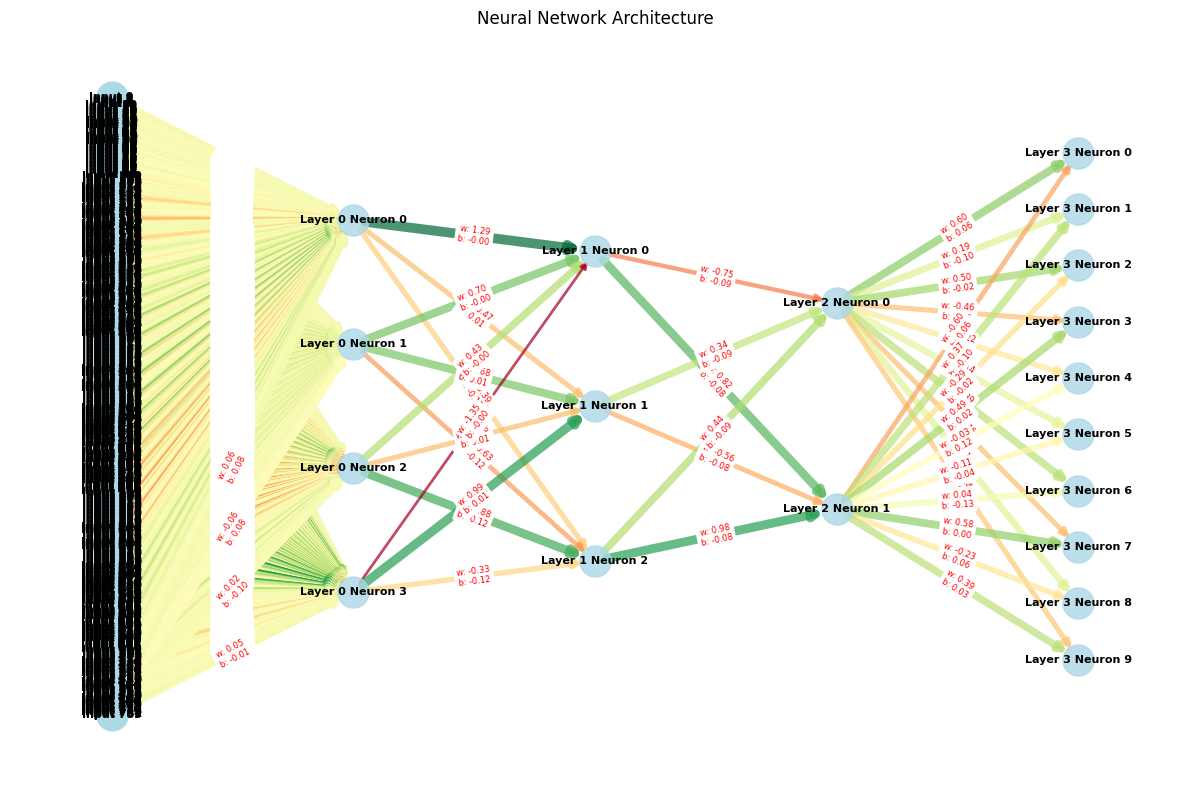

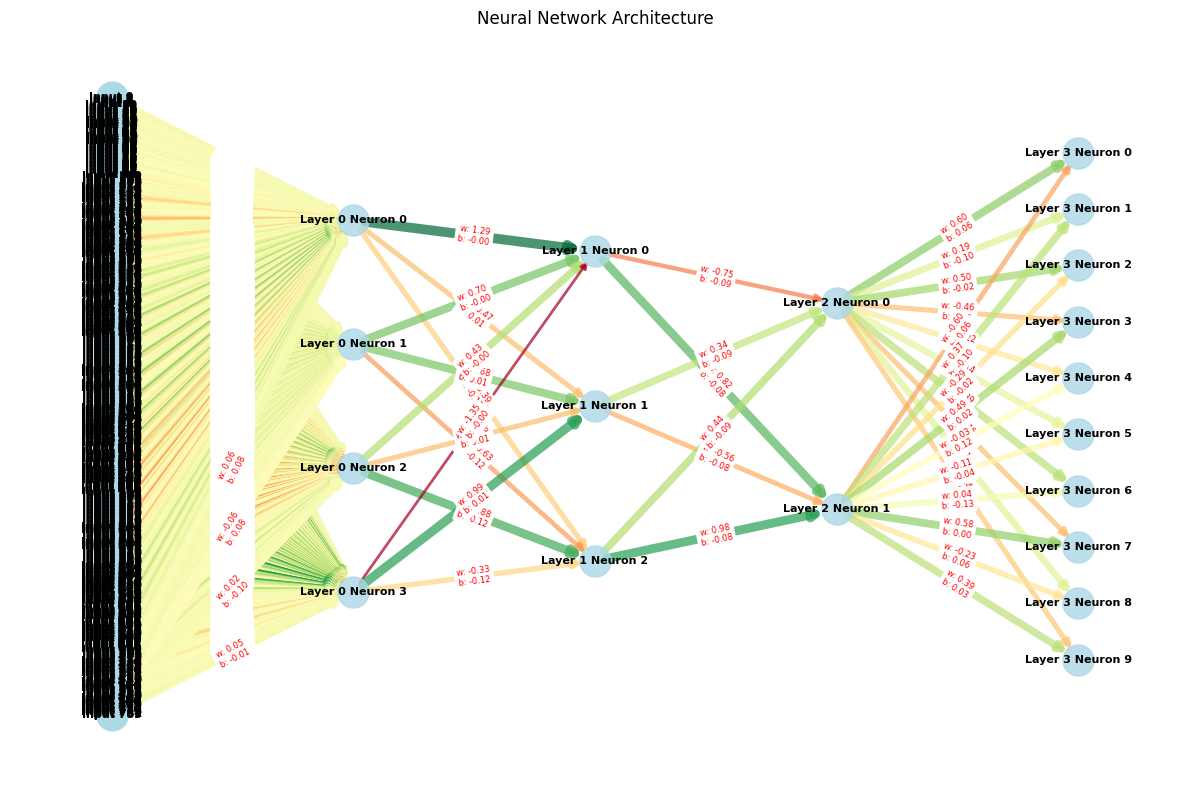

In [155]:
loaded_model.visualize_architecture()

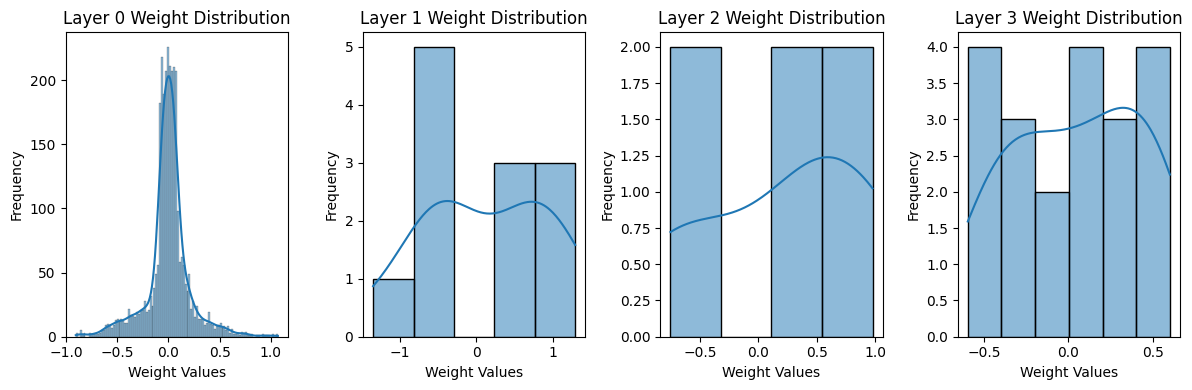

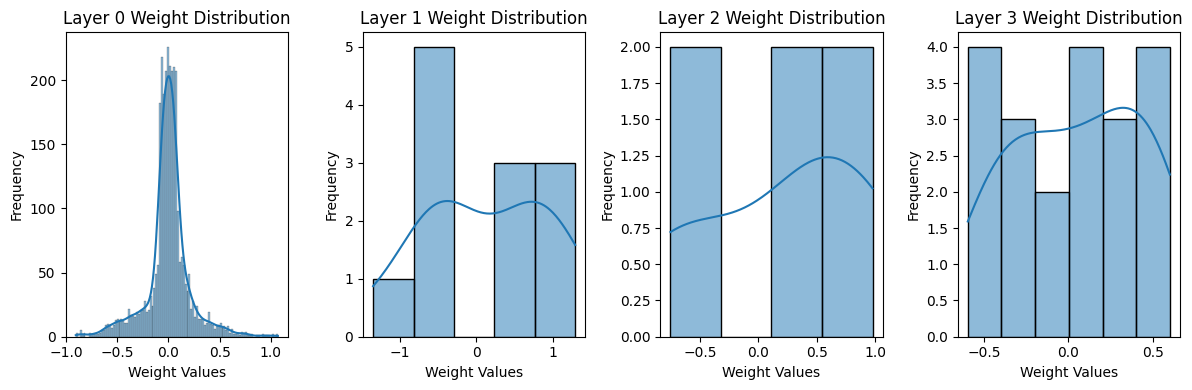

In [149]:
loaded_model.plot_weight_distribution()

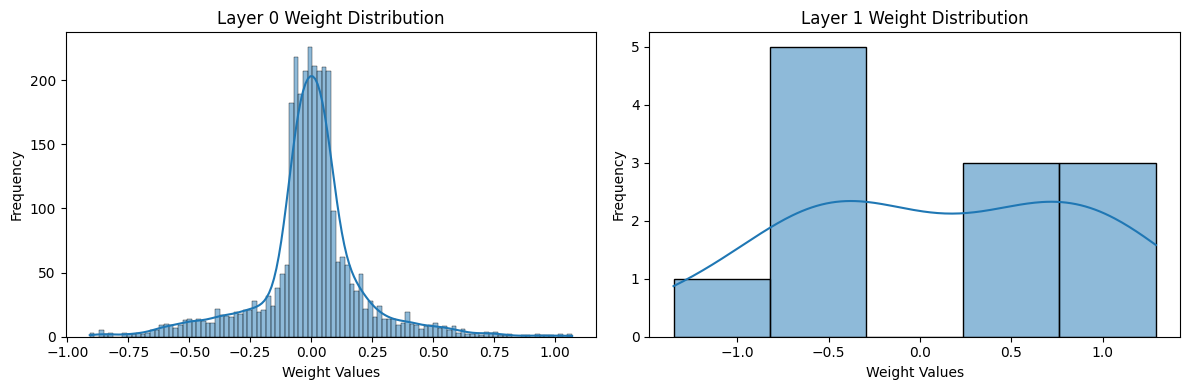

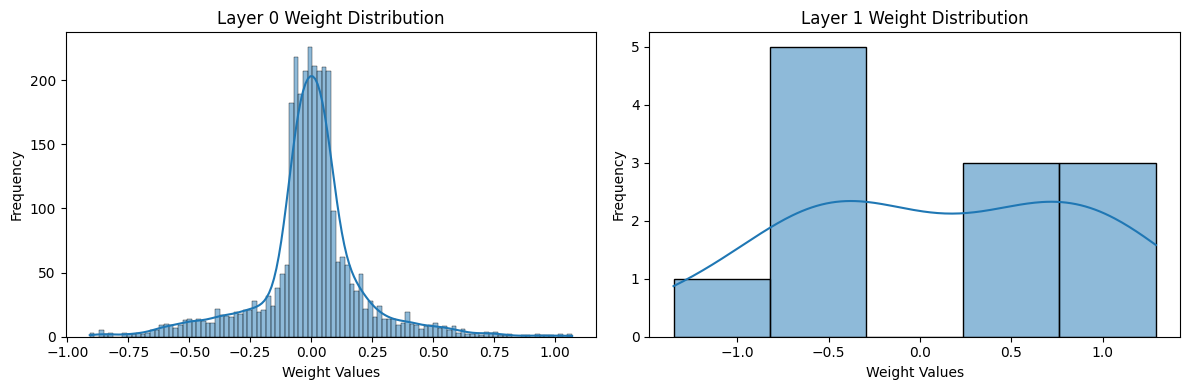

In [150]:
loaded_model.plot_weight_distribution(layers_to_plot=[0, 1])

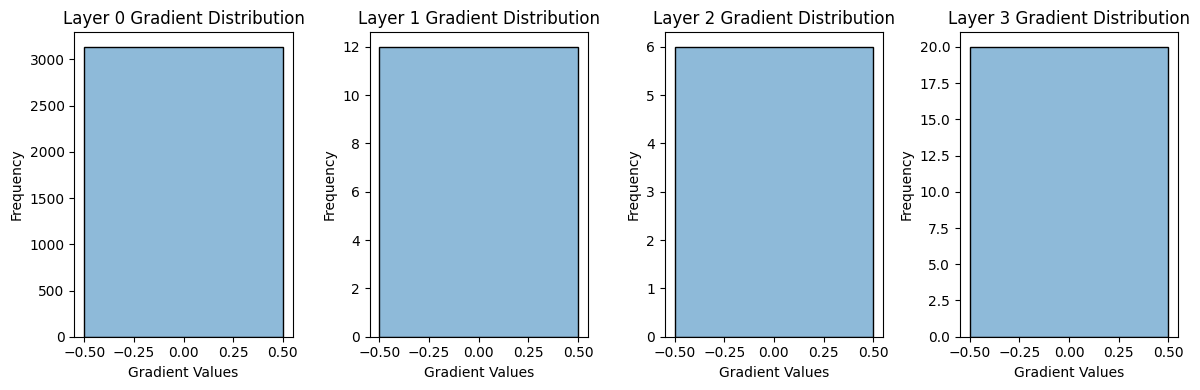

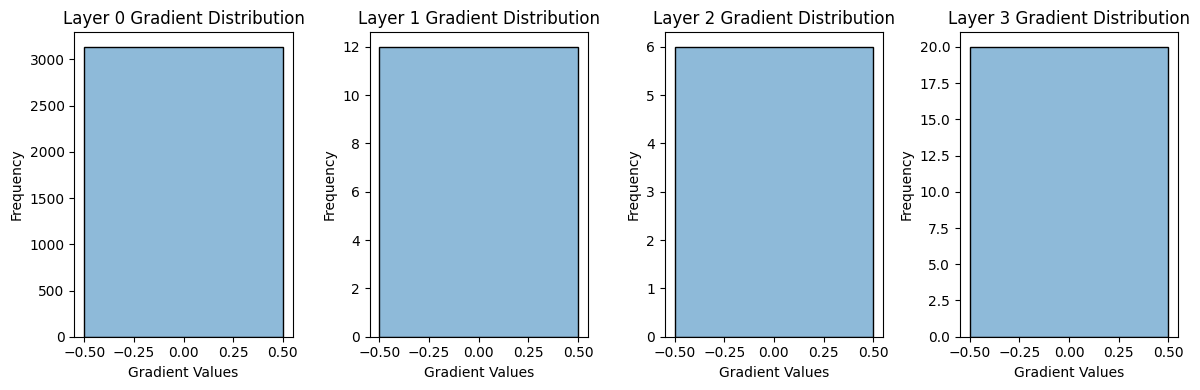

In [151]:
loaded_model.plot_gradient_distribution(X_train, y_train)

In [152]:
gradient_stats = loaded_model.compute_gradient_statistics(X_train, y_train)
for layer, stats in gradient_stats.items():
    print(f"Layer {layer} Gradient Statistics:")
    print(stats)

Layer 0 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 1 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 2 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 3 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}


In [153]:
X_train.shape

(52000, 784)